## Inversion for a coupled acoustic-gravity system

Before running `pip install tinyda ray' 

### Problem setup

Let $\varphi$ be the potential for the flow velocity, it is solution to 
\begin{align}\label{eq:forwardmodel}
    \frac{\partial^2 \varphi}{\partial t^2}
    - c^2 \Delta \varphi 
    + g \frac{\partial \varphi}{\partial z}
    = 0,  \quad \text{ in } \Omega,
    \\
    \frac{\partial^2 \varphi}{\partial t^2}
    + g \frac{\partial \varphi}{\partial z} 
    = 0, \quad \text{ on } \Gamma_s,
    \\
    \nabla \varphi \cdot {\bf n}
    = u_b, \quad \text{ on } \Gamma_b,
\end{align}
where $c$ is the (constant) sound speed, $g$ is the gravity acceleration, ${\bf n}$ is the outwards unit vector normal to the seabed $\Gamma_b$ and $u_b$ is the seabed velocity.
The fluid displacement $u$ is related to the potential by $u = \nabla \varphi$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

import tinyDA as tda
import umbridge

/home/anne/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-11-11 12:01:29,143	INFO util.py:154 -- Outdated packages:
  ipywidgets==6.0.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
np.random.seed(111)

### Initialising UM-Bridge
Before running the following cell, the model Docker image must be started from a system terminal using

`docker run -it -p 4242:4242 acousticgravity`

The Dockerfile can be found in the acousticgracity branch on UM-Bridge benchmarks. If not just running on a local machine replace `localhost` with the server.

In [3]:
# connect to the UM-Bridge model.
umbridge_model = umbridge.HTTPModel('http://localhost:4242', "forward")

# wrap the UM-Bridge model in the tinyDA UM-Bridge interface.
my_model = tda.UmBridgeModel(umbridge_model)

### Problem setup

In [4]:
# get the number of inputs and outputs.
nx = umbridge_model.get_input_sizes()[0] #the input is the location in x of the jump discontinuity
ny = umbridge_model.get_output_sizes()[0] #the outout is a time series of the pressure

#### TODO replace prior with levelset prior

In [5]:
# set the prior mean and covariance.
mean_prior = np.zeros(nx)  # zero corresponds to a fault at the center of the domain
cov_prior = 50*np.eye(nx)  # @Juliette: am I moving the fault by km or m?

# initialise the prior distribution and likelihood.
my_prior = multivariate_normal(mean_prior, cov_prior)

In [6]:
# generate synthetic data for input 0.5
# Input is a 30km wide fault centered around x
# Domain size is 150km
parameters = np.ndarray(nx)
parameters[0] = 0.5
d_true = my_model(parameters)

# add some noise to the model output
sigma_noise = 1
d = d_true + np.random.normal(loc=0, scale=sigma_noise, size=ny)

We plot only model output as the input is a simple 1D location so far

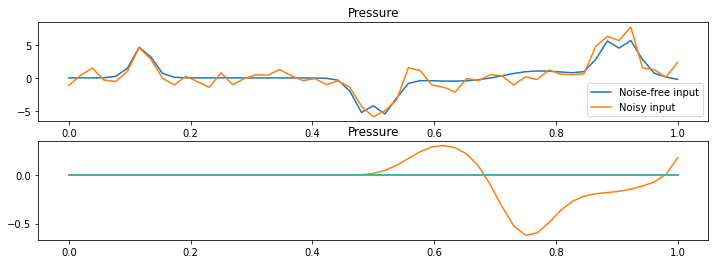

In [7]:
# plot the model output
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))

# plot the time series of pressure
t = np.linspace(0,1,ny)
ax[0].set_title('Pressure')
ax[0].plot(t,d_true, label='Noise-free input')
ax[0].plot(t,d, label='Noisy input')
ax[0].legend()

ax[1].set_title('Pressure')
# Plot 10 random samples
# @Juliette in most of these not much is happening, is this just because of the short end time?
for x in range(10):
    log = my_prior.rvs()
    d_sample = my_model(log)
    ax[1].plot(t, d_sample, label='samples')
plt.show()

Set up log-likelihood

#### TODO: Replace likelihood with and/or compare with Wasserstein distance

The "naive" choice seems to be causing some problems here. Juliette what would a reasonable distance be?

In [9]:
# set the covariance of the likelihood.
sigma = 0.1
cov_likelihood = sigma**2*np.eye(d.shape[0])

my_loglike = tda.GaussianLogLike(d, cov_likelihood)

# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [10]:
# preconditioned Crank-Nicolson
pcn_scaling = 0.1
pcn_adaptive = True
my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# random walk Metropolis
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

### Sample

In [11]:
# For testing purposes, iteration number is small for the given problem; Choose a larger number for real applications.
my_chains = tda.sample(my_posterior, my_proposal, iterations=10000, n_chains=2, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.95:   2%|██▊                                                                                                                                              | 194/10000 [01:00<55:27,  2.95it/s]/home/anne/.local/lib/python3.10/site-packages/tinyDA/proposal.py:340: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.likelihood - previous_link.likelihood)
Running chain, α = 0.25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:03:32<00:00,  2.62it/s]


Sampling chain 2/2


Running chain, α = 0.18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:33:26<00:00,  1.78it/s]


### Get some diagnostics

In [12]:
import arviz as az

In [13]:
# convert the tinyDA chains to an ArViz InferenceData object.
idata = tda.to_inference_data(my_chains, burnin=100)

/home/anne/.local/lib/python3.10/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [14]:
# display posterior summary statistics.
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.486,0.102,0.493,0.495,0.007,0.005,819.0,294.0,1.01
x1,-0.805,0.213,-1.057,-0.559,0.134,0.120,3.0,21.0,1.97


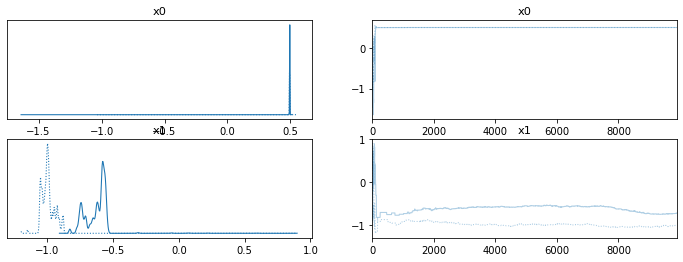

In [15]:
# plot posterior kernel densities and traces.
az.plot_trace(idata)
plt.show()

In [16]:
# extract the parameters from the chains.
parameters = [link.parameters for link in my_chains['chain_0'][2001:] + my_chains['chain_1'][2001:]]

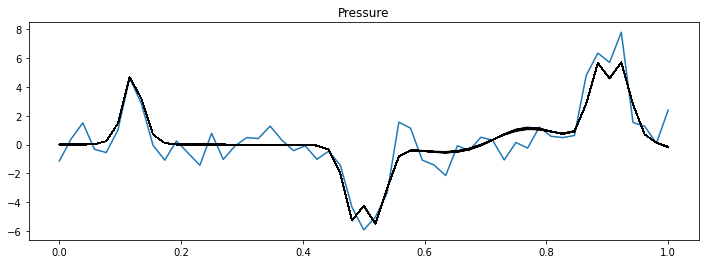

In [26]:
# plot some posterior draws of the model input and output.
n_samples = 1000
ids = np.random.randint(0, len(parameters), n_samples)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

# plot the output pressure
ax.set_title('Pressure')
ax.plot(np.linspace(0,1,ny), d)
for i in ids:
    ax.plot(np.linspace(0,1,ny), my_model(parameters[i]), c='k', alpha=0.01)
plt.show()

# Sequential MC

I've tried out this particle filter on an example they give. Laura, does the package contain anything useful?

In [28]:
from pfilter import ParticleFilter, independent_sample, squared_error
from scipy.stats import norm, gamma, uniform 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [29]:
def apply_filter(pf, ys, inputs=None):
    """Apply filter pf to a series of observations (time_steps, h)  and return a dictionary:    
        particles: an array of particles (time_steps, n, d)
        weights: an array of weights (time_steps,)        
    """

    states = []
    pf.init_filter()  # reset
    for i,y in enumerate(ys):
        if inputs is None:
            pf.update(y)
        else:
            pf.update(y, **inputs[i])
            
        states.append([pf.transformed_particles, np.array(pf.weights)])
    return {
        name: np.array([s[i] for s in states])
        for i, name in enumerate(["particles", "weights"])
    }

In [30]:
def plot_particles(x, y, yn, states):
    """Plot a 1D tracking result as a line graph with overlaid
    scatterplot of particles. Particles are sized according to
    normalised weight at each step.
    
        x: time values
        y: original (uncorrupted) values
        yn: noisy (observed) values
        states: dictionary return from apply_pfilter        
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, label='True', lw=1)
    ax.plot(x, yn, label='Noisy', lw=2)
    
    particles = states["particles"]
    ws = states["weights"]    
    means = np.sum(particles[:,:,0] * ws, axis=1)
    
    dev = (means - (particles[:,:,0]).T).T**2
    var = np.sum(ws * dev, axis=1)  / 1-np.sum(ws**2)  # unbiased variance
    stds = np.sqrt(var)
    
    ax.plot(x, means, 'C4', label='Mean est.', lw=4)
    ax.fill_between(x, means-stds, means+stds, color='C4', alpha=0.5, label='Std.')
    ax.scatter(np.tile(x, (len(particles[0]),1)).ravel(), particles[:,:,0].T, s=ws*1000/np.sqrt(len(ws)),
                alpha=0.15, label='Particles')
    ax.set_xlabel("Time")
    ax.set_ylabel("Observed")
    ax.legend()
    
def filter_plot(x, y, yn, pf, inputs=None):
    """Apply a filter to yn, and plot the results using plot_particles()"""
    states = apply_filter(pf, yn, inputs)
    plot_particles(x, y, yn, states)

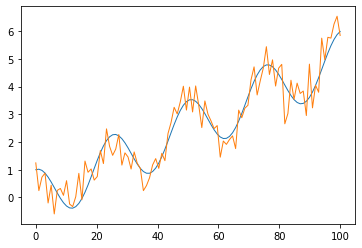

In [31]:
# Noisy sine wave data
x = np.linspace(0, 100, 100)
y = np.cos(x/4.0) + x * 0.05
yn = y + np.random.normal(0,0.5,x.shape)


fig, ax = plt.subplots()
ax.plot(x, y, label='True', lw=1)
ax.plot(x, yn, label='Noisy', lw=1)


/tmp/ipykernel_186154/4191983047.py:21: RuntimeWarning: invalid value encountered in sqrt
  stds = np.sqrt(var)


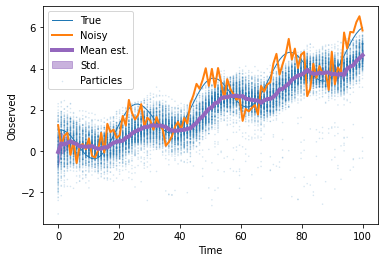

In [32]:
# No dynamics
# just diffusion on x
prior_fn = lambda n: np.random.normal(0,1,(n,1))
dt = 0.05
noise = 0.15
sigma = 1.5

pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = lambda x:  x,  
                    dynamics_fn=lambda x:   x ,
                    n_particles=250, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape),
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.01)

filter_plot(x, y, yn, pf)

# Level set priors

Some samples from 2D and 1D level sets. Comparing cut of a 2D level set and 1D.

In [33]:
%matplotlib inline
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['multivariate_normal', 'uniform', 'norm', 'log', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [34]:
# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

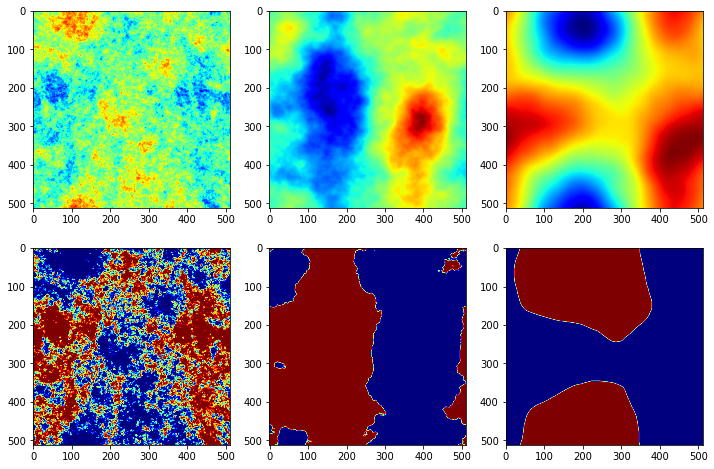

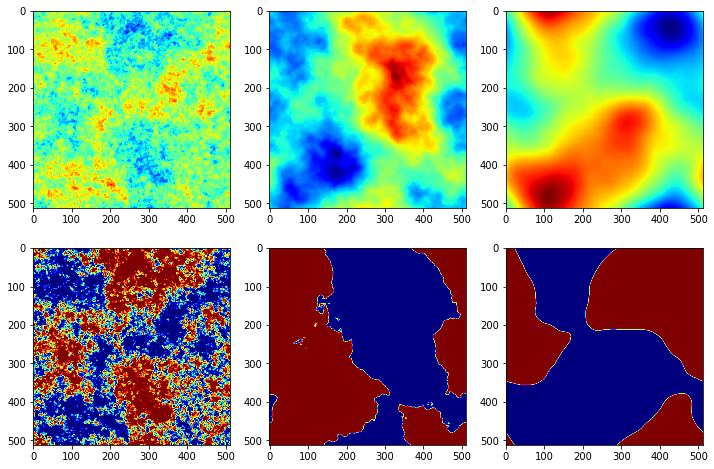

In [35]:
shape = (512, 512)
field1 = generate_field(distrib, Pkgen(2), shape)
field2 = generate_field(distrib, Pkgen(4), shape)
field3 = generate_field(distrib, Pkgen(6), shape)
field4 = generate_field(distrib, Pkgen(2), shape)
field5 = generate_field(distrib, Pkgen(4), shape)
field6 = generate_field(distrib, Pkgen(6), shape)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
ax[0,0].imshow(field1, cmap="jet")
ax[0,1].imshow(field2, cmap="jet")
ax[0,2].imshow(field3, cmap="jet")
ax[1,0].imshow(field1<0, cmap="jet")
ax[1,1].imshow(field2<0, cmap="jet")
ax[1,2].imshow(field3<0, cmap="jet")
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
ax[0,0].imshow(field4, cmap="jet")
ax[0,1].imshow(field5, cmap="jet")
ax[0,2].imshow(field6, cmap="jet")
ax[1,0].imshow(field4<0, cmap="jet")
ax[1,1].imshow(field5<0, cmap="jet")
ax[1,2].imshow(field6<0, cmap="jet")
plt.show()

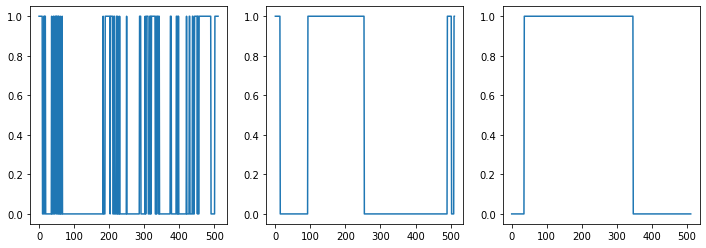

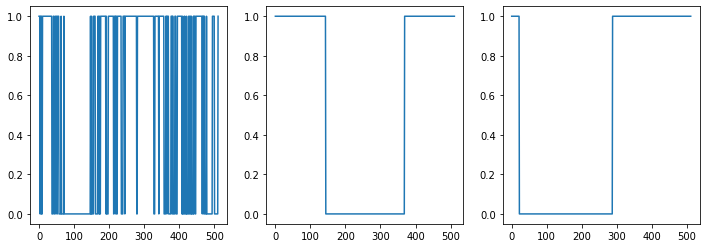

In [37]:
# Cross section of a 2D randomfield
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].plot(field1[0,:]<0)
ax[1].plot(field2[0,:]<0)
ax[2].plot(field3[0,:]<0)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].plot(field4[0,:]<0)
ax[1].plot(field5[0,:]<0)
ax[2].plot(field6[0,:]<0)
plt.show()

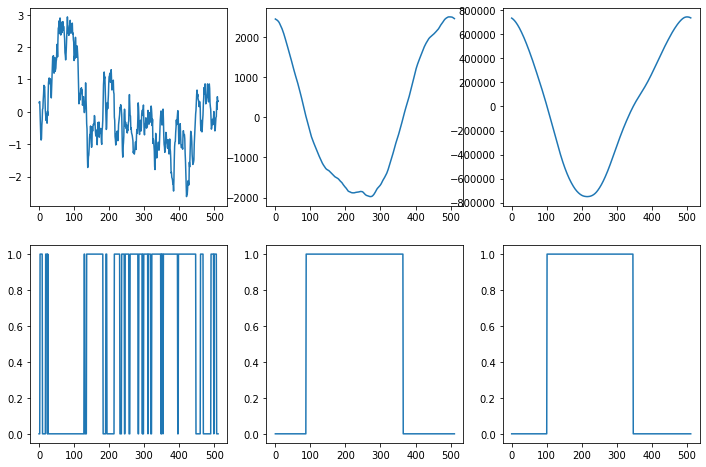

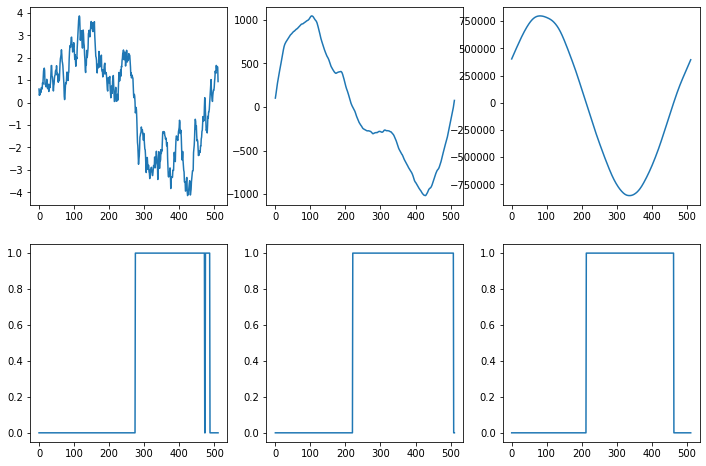

In [38]:
shape = (512, 1)
field1 = generate_field(distrib, Pkgen(2), shape)
field2 = generate_field(distrib, Pkgen(4), shape)
field3 = generate_field(distrib, Pkgen(6), shape)
field4 = generate_field(distrib, Pkgen(2), shape)
field5 = generate_field(distrib, Pkgen(4), shape)
field6 = generate_field(distrib, Pkgen(6), shape)

# 1D levelset
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

ax[0,0].plot(field1)
ax[0,1].plot(field2)
ax[0,2].plot(field3)
ax[1,0].plot(field1<0)
ax[1,1].plot(field2<0)
ax[1,2].plot(field3<0)
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

ax[0,0].plot(field4)
ax[0,1].plot(field5)
ax[0,2].plot(field6)
ax[1,0].plot(field4<0)
ax[1,1].plot(field5<0)
ax[1,2].plot(field6<0)
plt.show()